# Doctoplant - Discover diseases on leaves photos.

## Iteration 3:
1. Random Background
2. Sigmoid


## 1. Environment preparation
1. Make sure TensorFlow is installed 
2. Check if Drive is connected
3. Unzip dataset
4. Check if we are connected to GPU

It's faster to copy the Dataset from our own Drive to Collab environment. And from there, unzip the Dataset and start working on it.

It takes overall less than 5 minutes to copy and unzip the whole Dataset, so it worth it to follow this process.

In [ ]:
# Import TensorFlow into collab
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


In [ ]:
# Import Drive (to execute only ONCE)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip Background images (to execute only ONCE)
!unzip -u '/content/sample_data/bckgrnd_img.zip' -d '/content/sample_data'
# Unzip Dataset (to execute only ONCE)
!unzip -u "/content/sample_data/plantvillage_dataset_augmented_fixed.zip" -d "/content/sample_data"

Archive:  /content/sample_data/bckgrnd_img.zip
   creating: /content/sample_data/bckgrnd_img/
   creating: /content/sample_data/bckgrnd_img/Apple/
   creating: /content/sample_data/bckgrnd_img/Blueberry/
   creating: /content/sample_data/bckgrnd_img/Strawberry/
  inflating: /content/sample_data/bckgrnd_img/.DS_Store  
  inflating: /content/sample_data/__MACOSX/bckgrnd_img/._.DS_Store  
   creating: /content/sample_data/bckgrnd_img/Soybean/
   creating: /content/sample_data/bckgrnd_img/Squash/
   creating: /content/sample_data/bckgrnd_img/Potato/
   creating: /content/sample_data/bckgrnd_img/Pepper,_bell/
   creating: /content/sample_data/bckgrnd_img/Raspberry/
   creating: /content/sample_data/bckgrnd_img/Cherry_(including_sour)/
   creating: /content/sample_data/bckgrnd_img/Corn_(maize)/
   creating: /content/sample_data/bckgrnd_img/Grape/
   creating: /content/sample_data/bckgrnd_img/Tomato/
   creating: /content/sample_data/bckgrnd_img/Orange/
   creating: /content/sample_data/bckgr

In [ ]:
# Unzip folders (to execute only ONCE)
!unzip -u '/content/drive/MyDrive/20 - Data/Last Version/dataset_test_v3.zip' -d '/content/sample_data/dataset_test'
!unzip -u "/content/drive/MyDrive/20 - Data/Last Version/plantvillage_dataset_augmented_fixed.zip" -d "/content/sample_data"
!unzip -u "/content/drive/MyDrive/20 - Data/Last Version/bckgrnd_img.zip" -d "/content/sample_data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im39312.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im39312.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im42978.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im42978.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im41281.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im41281.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im42788.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im42788.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im42950.jpg  
  inf

### Use of GPU

For the purpose of Image Classification, we will use Google GPU to allow us to use Google resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 2. Code - preparation and training CNN

As we have already performed the DataViz and Data Exploration, we can directly work on our CNN model.
We need:
1. Import the required libraries
2. Create a DataFrame with all information
3. Prepare Data (train/validation)
4. Create Datasets
5. Create CNN model
6. Train our model


### 1. Import the required libraries

In [ ]:
# Import required packages
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Rename Classe other to be in a fist position in a one hot vector
os.rename("/content/sample_data/plantvillage_dataset_augmented/Others___Others", "/content/sample_data/plantvillage_dataset_augmented/0-Others___Others")
os.rename("/content/sample_data/dataset_test/Others___Others", "/content/sample_data/dataset_test/0-Others___Others")

### 2. Create DataFrame 

We will create DataFrame to store required information for our script.

Dataframe composed of:
- List of Plants name (plant)
- List of Plants Categories (category)
- List of images path (img_path) > Features
- List of Plants name + Plants Categories (plant___category) > Labels
- Background of the leaves plant. For other Category no background is required (back_path)

In [ ]:
import glob
# Get Path to Image folders
IMG_PATH = '/content/sample_data/plantvillage_dataset_augmented'
BCK_PATH = '/content/sample_data/bckgrnd_img'
BCK_FILES = {root: files for root, _, files in os.walk(BCK_PATH)}

# Image size
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BUFFER_SIZE = 1000
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [ ]:
def get_random_bckg(plant):
  bckgrd_img_path = BCK_PATH +'/'+plant
  bckgrd_img = np.random.choice(BCK_FILES[bckgrd_img_path])

  return os.path.join(bckgrd_img_path, bckgrd_img)

# Create Dataframe
def create_info_df(dir_path):

  list_plants = []
  img_listdir = glob.glob(os.path.join(dir_path, '*'))

  for img_dir in img_listdir:
    plant = img_dir.split('/')[-1]

    for img in os.listdir(img_dir):
      list_plants.append([*plant.split('___'), os.path.join(img_dir,img), plant])

  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])
  df['back_path'] = df['plant'].apply(lambda x: x if x == '0-Others' else get_random_bckg(x))

  return df

# Get DF
df_info = create_info_df(IMG_PATH)
print("DF Info shape: ", df_info.shape)

#Unique label list:
# Unique label list:
unique_plant_cat = np.unique(df_info['plant___category'][df_info['plant']!='Others'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class = unique_plant_cat.tolist()

# Label Integer
df_info['label_int'] = df_info['plant___category'].apply(lambda x: list_class.index(x))

DF Info shape:  (114077, 5)
Number of Categories to predict:  39


In [ ]:
unique_plant_cat

array(['0-Others___Others', 'Apple___Apple_scab', 'Apple___Black_rot',
       'Apple___Cedar_apple_rust', 'Apple___healthy',
       'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
       'Cherry_(including_sour)___healthy',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
       'Corn_(maize)___Common_rust_',
       'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
       'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
       'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
       'Orange___Haunglongbing_(Citrus_greening)',
       'Peach___Bacterial_spot', 'Peach___healthy',
       'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
       'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
       'Strawberry___healthy', 'Tomato___Bacterial_spot',
       'Tomato___Early_blight', 'Tomat

In [ ]:
df_info['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
0-Others___Others                                     5000
Tomato___Late_blight                                  3818
Squash___Powdery_mildew                               3670
Tomato___Septoria_leaf_spot                           3542
Tomato___Spider_mites Two-spotted_spider_mite         3352
Apple___healthy                                       3290
Tomato___healthy                                      3182
Blueberry___healthy                                   3004
Potato___Late_blight                                  3000
Tomato___Early_blight                                 3000
Potato___Early_blight                                 3000
Pepper,_bell___Bacterial_spot                         2991
Pepper,_bell___healthy                                2956
Corn_(maize)___Northern_Leaf_Blight                   29

### 3. Prepare Data

Functions utils

In [ ]:
# Functions
LIST_CLASS_LEN = len(list_class)

def split_data(df, frac=1):
  """
    Get Dataframe and split it in Train and Validation DataFrame.
    Train: 80% of full data
    Validation: 20% of Data
  """
  df = df.sample(frac=frac, random_state=42).reset_index()
  split_size = round(len(df)*80/100)
  train = df.iloc[:split_size]
  valid = df.iloc[split_size:]

  return train, valid

def decode_img(path, label, back, image_shape=IMG_SHAPE):
  """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    return: resized tensor image and label
  """
  # Threshold for background
  threshold = 10

  # Read the image file
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, image_shape[:2]) # Resize image to our desired size

  # Transform label integer to one hot vector
  label_one_hot = tf.one_hot(label,depth=LIST_CLASS_LEN)

  if back == '0-Others':
    return tf.cast(img, tf.float32)/255, label_one_hot

  bkg = tf.io.read_file(back)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  bkg = tf.image.resize(bkg, image_shape[:2]) # Resize image to our desired size

  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(n_img, tf.float32)/255, label_one_hot


def create_dataset(datapoint, valid_data=False):
  X, y, back = datapoint['img_path'], datapoint['label_int'], datapoint['back_path']

  # For Validation set - We do not shuffle
  if valid_data:
    print('Creation of the validation dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  # For Training set
  else:
    print('Creation of the Training dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset


# Save and load model
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in ad models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("drive/My Drive/DataScientest/30 - Models/saved_models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Save model to: {model_path}...")
    model.save(model_path)

    return model_path


def display_imgs(display_list, label=None):
  plt.figure(figsize=(16,16))

  labels = ['Image '+label, 'Background', ' Image with Background']

  for i, data in enumerate(display_list):
    plt.subplot(1,len(display_list)+1, i+1)
    plt.imshow(np.squeeze(data).astype('uint8'))
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(data))
    plt.title(labels[i])
    plt.axis('off')
  plt.show()

The Dataset is a leaf image with Black background.
To help the model recognize a leaf from a photo taken in a natural environment, we will add a backgound (of a plants) in each images.

This process will be done "*on the fly*" to avoid creating a new dataset.

The process is as follow:
- Take the leaf image with black background and convert it to an array.
> When the image is converted to an array, a black pixel is represented by 0.
- For every pixel (converted to a number) below a chosen threshold, replace the pixel with the pixel from the backgound image.
> we use `tf.where(pixel_img < threshold, pixel_backgrnd, pixel_img)`. We can translate it as: 
> - if **pixel_image** is below **threshold**, use **pixel_backgrnd**
> - else, use **pixel_img**

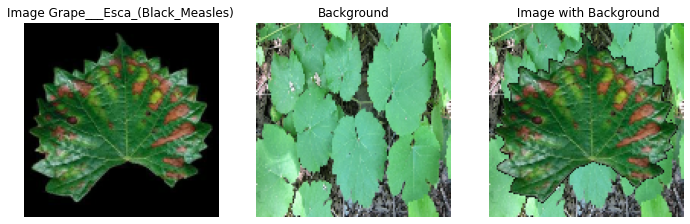

In [ ]:
# Let's see an example:
random = np.random.randint(0, len(df_info))

def get_img_bck(img_path, bckgrnd_path):
  # Threshold for background
  threshold = 10
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize image to our desired size
  img = tf.image.resize(img, IMG_SHAPE[:2])

  bkg = tf.io.read_file(bckgrnd_path)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  # Resize image to our desired size
  bkg = tf.image.resize(bkg, IMG_SHAPE[:2])
  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return img, bkg, n_img

imgs_list = list(get_img_bck(df_info.iloc[random]['img_path'], df_info.iloc[random]['back_path']))

display_imgs(imgs_list, df_info.iloc[random]['plant___category'])

Split Data to Validation set and Train set.

In [ ]:
train, valid = split_data(df_info)
print("Train df shape: ", train.shape)
print("Valid df shape: ", valid.shape)

Train df shape:  (91262, 7)
Valid df shape:  (22815, 7)


In [ ]:
train['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              4461
Tomato___Tomato_Yellow_Leaf_Curl_Virus                4246
Soybean___healthy                                     4065
0-Others___Others                                     4009
Tomato___Late_blight                                  3074
Squash___Powdery_mildew                               2897
Tomato___Septoria_leaf_spot                           2840
Tomato___Spider_mites Two-spotted_spider_mite         2685
Apple___healthy                                       2621
Tomato___healthy                                      2533
Tomato___Early_blight                                 2425
Pepper,_bell___Bacterial_spot                         2421
Blueberry___healthy                                   2401
Potato___Late_blight                                  2397
Corn_(maize)___Northern_Leaf_Blight                   2378
Potato___Early_blight                                 2364
Pepper,_bell___healthy                                23

In [ ]:
valid['plant___category'].value_counts()

Tomato___Tomato_Yellow_Leaf_Curl_Virus                1111
Orange___Haunglongbing_(Citrus_greening)              1046
Soybean___healthy                                     1025
0-Others___Others                                      991
Squash___Powdery_mildew                                773
Tomato___Late_blight                                   744
Tomato___Septoria_leaf_spot                            702
Apple___healthy                                        669
Tomato___Spider_mites Two-spotted_spider_mite          667
Tomato___healthy                                       649
Potato___Early_blight                                  636
Pepper,_bell___healthy                                 635
Tomato___Leaf_Mold                                     614
Tomato___Target_Spot                                   603
Blueberry___healthy                                    603
Potato___Late_blight                                   603
Corn_(maize)___Northern_Leaf_Blight                    5

### 4. Create Datasets

In [ ]:
dataset_train = create_dataset(train)
dataset_valid = create_dataset(valid, valid_data=True)

Creation of the Training dataset...
Creation of the validation dataset...


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


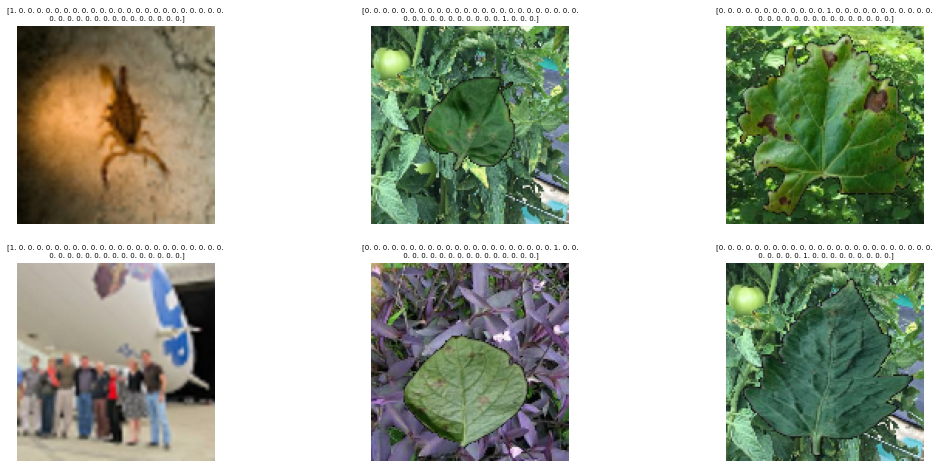

In [ ]:
# Check if records are well created in datasets
img_batch, label_batch = next(iter(dataset_train))

plt.figure(figsize=(18, 8))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow((img_batch[i].numpy()*255).astype("uint8"))
  #label = label_batch[i][1:]==1
  label = label_batch[i].numpy()

  #plt.title(unique_plant_cat[label])
  plt.title(label,fontsize=7)
  plt.axis("off")

### 5. Create CNN model

We create our own CNN model.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

regularizer = tf.keras.regularizers.l2(5e-3)

INPUT_SHAPE = IMG_SHAPE

def model_CNN():
  input_model = Input(shape=INPUT_SHAPE)

  x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizer)(input_model)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
 
  x = Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizer)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  #x = Flatten()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu', kernel_regularizer=regularizer)(x)
  x = Dropout(0.2)(x)
  x = Dense(256, activation='relu', kernel_regularizer=regularizer)(x)
  x = Dropout(0.2)(x)

  object_prob = Dense(1, activation='sigmoid', name='object_output')(x)
  plants_prob = Dense(38, activation='softmax', name = 'plant_output')(x)

  output_model = tf.concat([object_prob, plants_prob], axis=-1)

  model = Model(inputs=input_model, outputs=output_model)

  return model

model = model_CNN()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 126, 126, 128 512         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 128)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

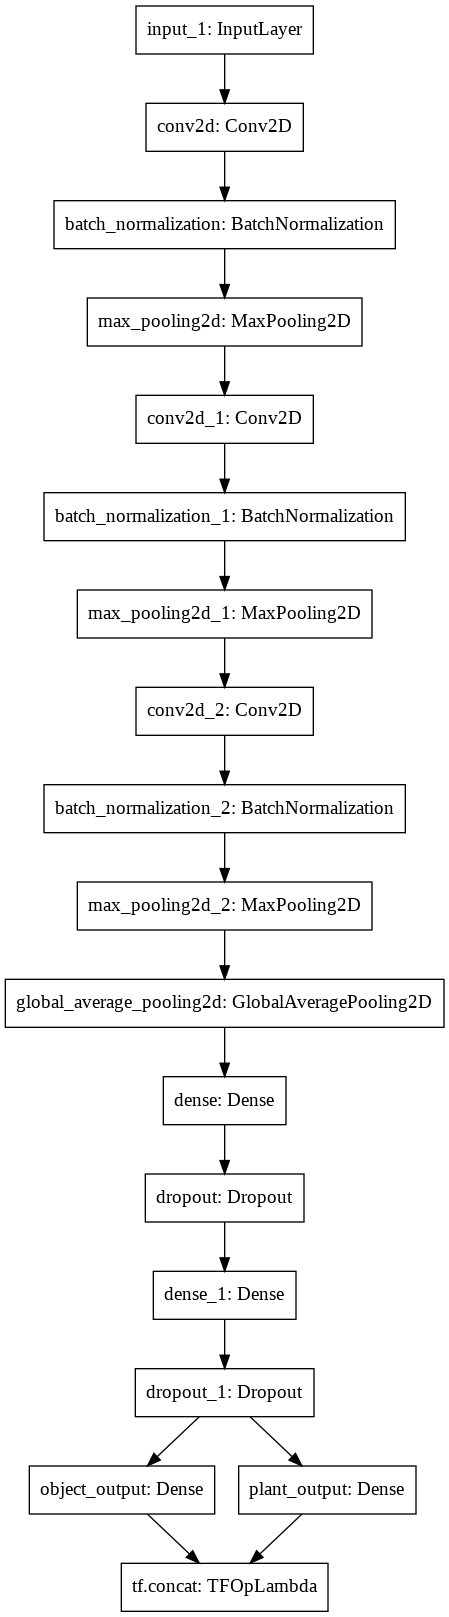

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import tensorflow.keras.backend as K

lambda_plant_class = 1
lambda_object_class = 1
init_lr = 0.0005

num_of_ones = 5000
total = 114000#df_info.shape[0]

weight_one = total/(2*num_of_ones)

def weighted_bincrossentropy(true, pred, weight_zero = 1, weight_one = weight_one):
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return K.mean(weighted_bin_crossentropy)


def weighted_binary_crossentropy( y_true, y_pred, weight=weight_one) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

def my_custom_loss(y_true, y_pred):
  return (1-y_true[:,0])*lambda_plant_class*CategoricalCrossentropy()(y_true[:,1:], y_pred[:,1:]) + lambda_object_class*weighted_bincrossentropy(y_true[:,0], y_pred[:,0])


model.compile(loss=my_custom_loss, optimizer=Adam(lr=init_lr), metrics=['accuracy', tf.keras.metrics.Recall()])

We will create two Callbacks:
- **Early stopping**: to stop training of the model if the validation accuracy is not moving down after 3 epochs.
- **Reduce Learning Rate**: To reduce the learning rate of Adam optimizer, if the Validation loss is not reducing after 3 epochs.

In [ ]:
# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# Reduce learning rate after 4 Epoch
def scheduler(epoch, lr):
  if epoch %3== 0:
    return lr * 0.2
  else:
    return lr

lr_callback =tf.keras.callbacks.LearningRateScheduler(scheduler)

### 6. Start Training model

Training on the whole dataset can take at least an hour. Once the training is done we will save the model, so we can use it or share it with anyone.



In [ ]:
# TEST WITH WEIGHTED BCE
NUM_EPOCHS = 20

# Train Model
history = model.fit(dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_valid,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc, val_recall = model.evaluate(dataset_valid)
val_acc = round(val_acc, 3)

# Save model
suffix = 'CNN_iteration_3_random_backgrnd_sigmoid_acc-'+str(val_acc)
save_model(model, suffix=suffix)

Epoch 1/20
2852/2852 [==============================] - 868s 300ms/step - loss: 7.2588 - accuracy: 0.3907 - recall_1: 0.2221 - val_loss: 3.2482 - val_accuracy: 0.7002 - val_recall_1: 0.5680
Epoch 2/20
2852/2852 [==============================] - 836s 291ms/step - loss: 2.4976 - accuracy: 0.8094 - recall_1: 0.7040 - val_loss: 2.2702 - val_accuracy: 0.6452 - val_recall_1: 0.5859
Epoch 3/20
2852/2852 [==============================] - 831s 289ms/step - loss: 1.2621 - accuracy: 0.8840 - recall_1: 0.8198 - val_loss: 1.1251 - val_accuracy: 0.8363 - val_recall_1: 0.7474
Epoch 4/20
2852/2852 [==============================] - 826s 287ms/step - loss: 0.8143 - accuracy: 0.9335 - recall_1: 0.8954 - val_loss: 0.6841 - val_accuracy: 0.9538 - val_recall_1: 0.9304
Epoch 5/20
2852/2852 [==============================] - 795s 276ms/step - loss: 0.7121 - accuracy: 0.9412 - recall_1: 0.9083 - val_loss: 0.6424 - val_accuracy: 0.9453 - val_recall_1: 0.9233
Epoch 6/20
2852/2852 [============================

'drive/My Drive/DataScientest/30 - Models/saved_models/20210302-1157-CNN_iteration_3_random_backgrnd_sigmoid_acc-0.972.h5'

# Evaluate Model

## Test Dataset

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DataScientest/30 - Models/saved_models/20210302-1157-CNN_iteration_3_random_backgrnd_sigmoid_acc-0.972.h5',
                                   custom_objects={'my_custom_loss':my_custom_loss})

In [ ]:
TEST_PATH = '/content/sample_data/dataset_test'

# Create Dataframe
def create_test_df(dir_path):

  list_plants = []
  img_listdir = glob.glob(os.path.join(dir_path, '*'))

  for img_dir in img_listdir:
    plant = img_dir.split('/')[-1]

    for img in os.listdir(img_dir):
      list_plants.append([*plant.split('___'), os.path.join(img_dir,img), plant])

  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])

  return df

# Get DF
test_info = create_test_df(TEST_PATH)
print("Test Info shape: ", test_info.shape)

# Unique label list:
unique_plant_cat = np.unique(test_info['plant___category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class = unique_plant_cat.tolist()

# Label Integer
test_info['label_int'] = test_info['plant___category'].apply(lambda x: list_class.index(x))

def get_label(label_int, list_class=list_class):
  return list_class[np.argmax(label_int)]

Test Info shape:  (1523, 4)
Number of Categories to predict:  39


In [ ]:
test_info.head()

,plant,category,img_path,plant___category,label_int
0,Cherry_(including_sour),Powdery_mildew,/content/sample_data/dataset_test/Cherry_(incl...,Cherry_(including_sour)___Powdery_mildew,6
1,Cherry_(including_sour),Powdery_mildew,/content/sample_data/dataset_test/Cherry_(incl...,Cherry_(including_sour)___Powdery_mildew,6
2,Cherry_(including_sour),Powdery_mildew,/content/sample_data/dataset_test/Cherry_(incl...,Cherry_(including_sour)___Powdery_mildew,6
3,Cherry_(including_sour),Powdery_mildew,/content/sample_data/dataset_test/Cherry_(incl...,Cherry_(including_sour)___Powdery_mildew,6
4,Cherry_(including_sour),Powdery_mildew,/content/sample_data/dataset_test/Cherry_(incl...,Cherry_(including_sour)___Powdery_mildew,6


In [ ]:
LIST_CLASS_LEN = len(list_class)

def decode_img_test(img_path, label, image_shape=IMG_SHAPE):
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, image_shape[:2]) # Resize image to our desired size

  # Transform label integer to one hot vector
  label_one_hot = tf.one_hot(label,depth=LIST_CLASS_LEN)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(img, tf.float32)/255, label_one_hot

X, y = test_info['img_path'], test_info['label_int']

print('Creation of the test dataset...')
dataset_test = tf.data.Dataset.from_tensor_slices((X, y))
dataset_test = dataset_test.map(decode_img_test, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Get Validation Loss and Accuracy
val_loss_test, val_acc_test, val_recall_test = model.evaluate(dataset_test)
val_acc_test = round(val_acc_test, 3)
print(f'Accuracy for test DataSet: {val_acc_test*100:.2f}%')

Creation of the test dataset...
48/48 [==============================] - 10s 49ms/step - loss: 5.2320 - accuracy: 0.1924 - recall_1: 0.1405
Accuracy for test DataSet: 19.20%


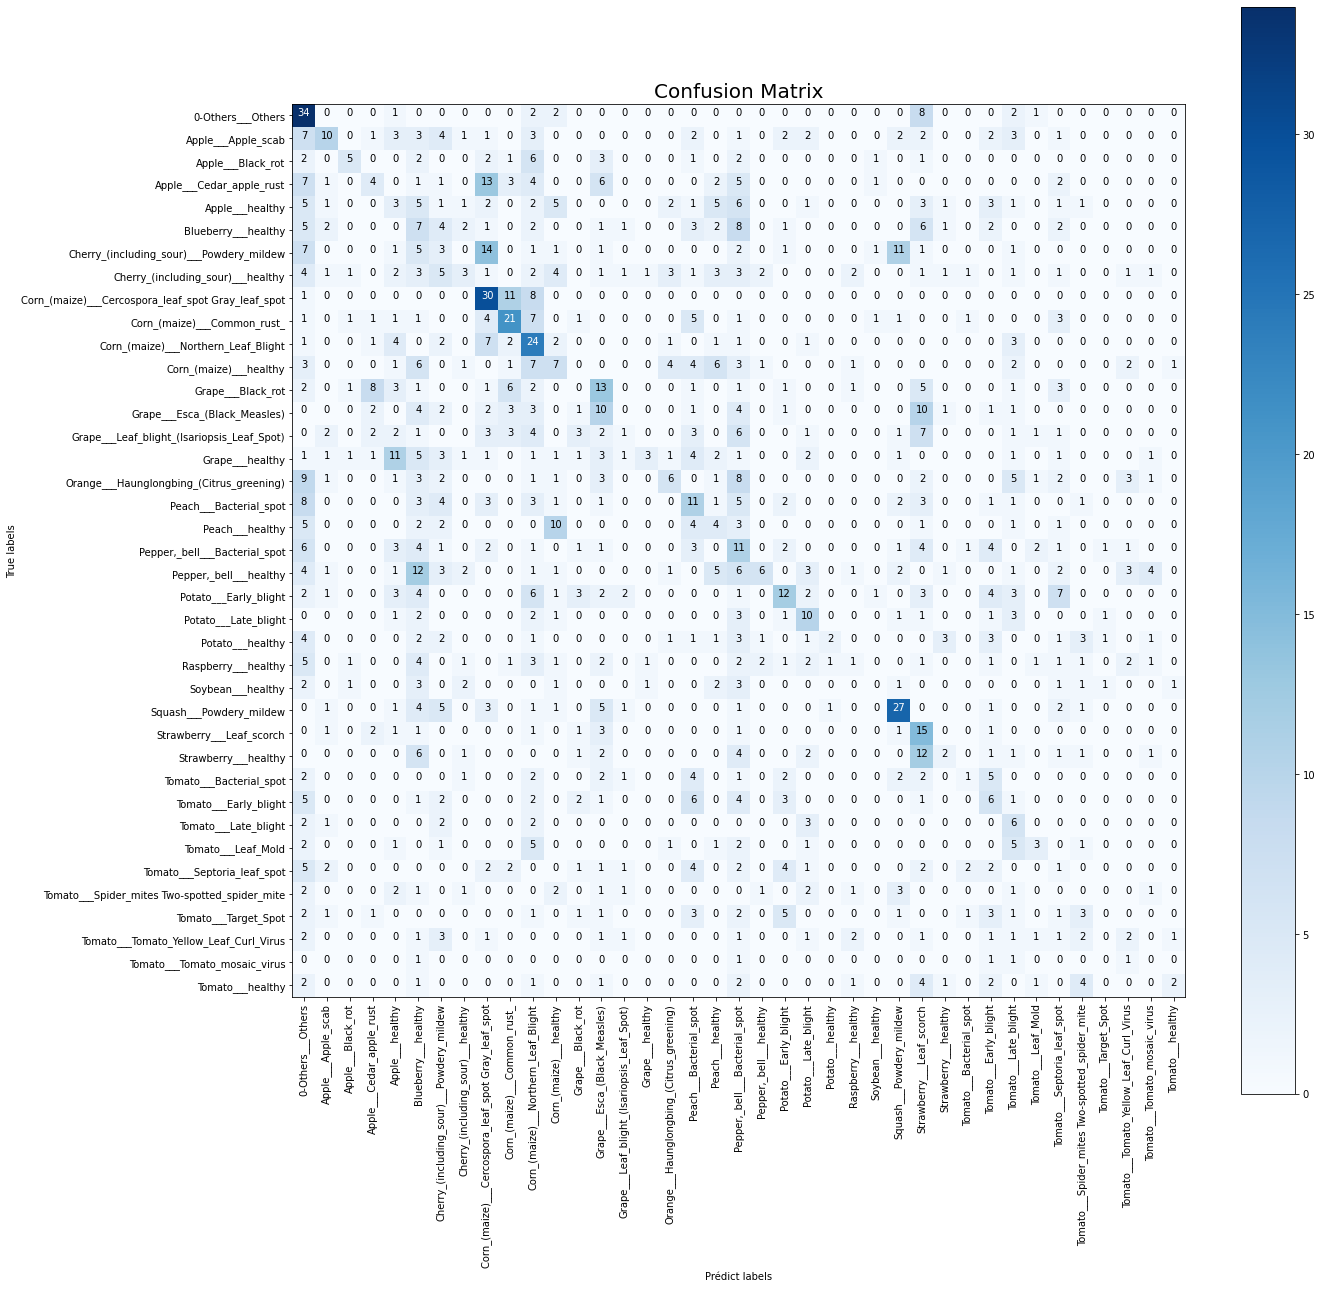

In [ ]:
# Get predictions
predictions_test = model.predict(dataset_test)
predictions_test_int = np.argmax(predictions_test, axis=1)
# Get Validation datset images and true labels
imgs_test, labels_test = unbatchify(dataset_test)

get_confusion_matrix(labels_test, predictions_test_int)

## Validation Dataset

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image)
        lbl.append(np.argmax(label))

    return img,lbl


# Show images and prediction rate
def show_img_and_prediction(model, dataset_valid, nb_img=9):
    """
      Take model and validation dataset.
      Unbatch validation dataset to get the images and tru labels
      Show 9 random images with the 
        - predicted label (with the percent of prediction)
        - the image model tried to predict
        - the true label
    """
    # Get predictions
    predictions = model.predict(dataset_valid)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_valid)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red' # by default, color of the title is red

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        # If the predicted label is the same as the true label, change color of the title to green
        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));  


def plot_acc_and_loss(history):
  """
  From Model History, plot two Graphs: 
   - Accuracy Train + Validation
   - Loss Train + Validation

  Input: model history
  """
  # Get Accuracy from History model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  # Get Loss from History model
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  
  plt.figure(figsize=(16,10))
  # Accuracy subplot
  plt.subplot(121)
  plt.plot(epochs, acc, color='red', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend()

  # Loss subplot
  plt.subplot(122)
  plt.plot(epochs, loss, color='orange', label='Training Loss')
  plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.legend()


# Confusion matrix
from sklearn import metrics
import itertools

def get_confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()

### 1. Plot Accuracy & Loss

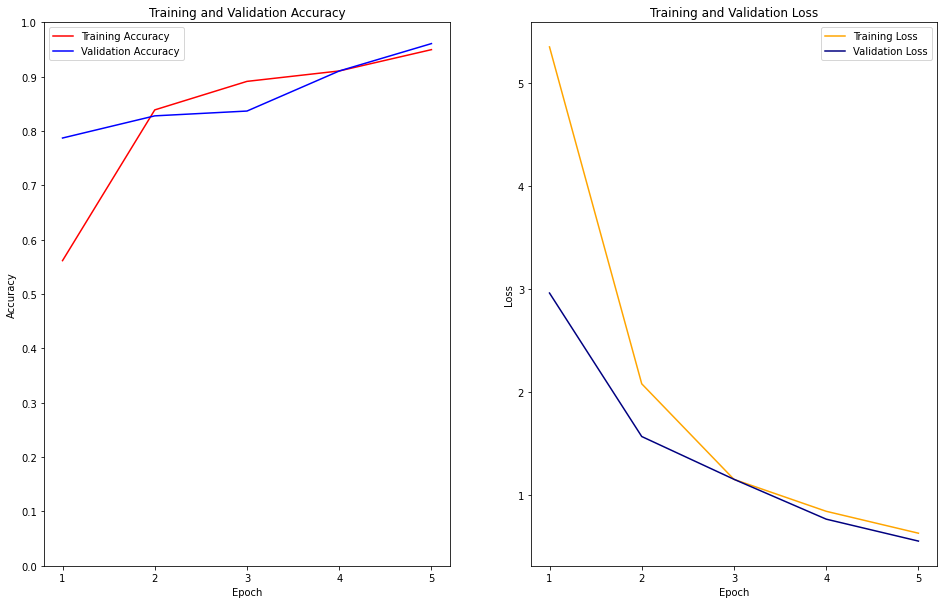

In [ ]:
# Plot Accuracy & Loss
plot_acc_and_loss(history)

### 2. Predictions from Valid Dataset

### 3. Confusion Matrix

In [ ]:
# Get predictions
predictions = model.predict(dataset_valid)
pred_labels = np.argmax(predictions, axis=1)
# Get Validation dataset Images and True Labels
imgs, labels = unbatchify(dataset_valid)

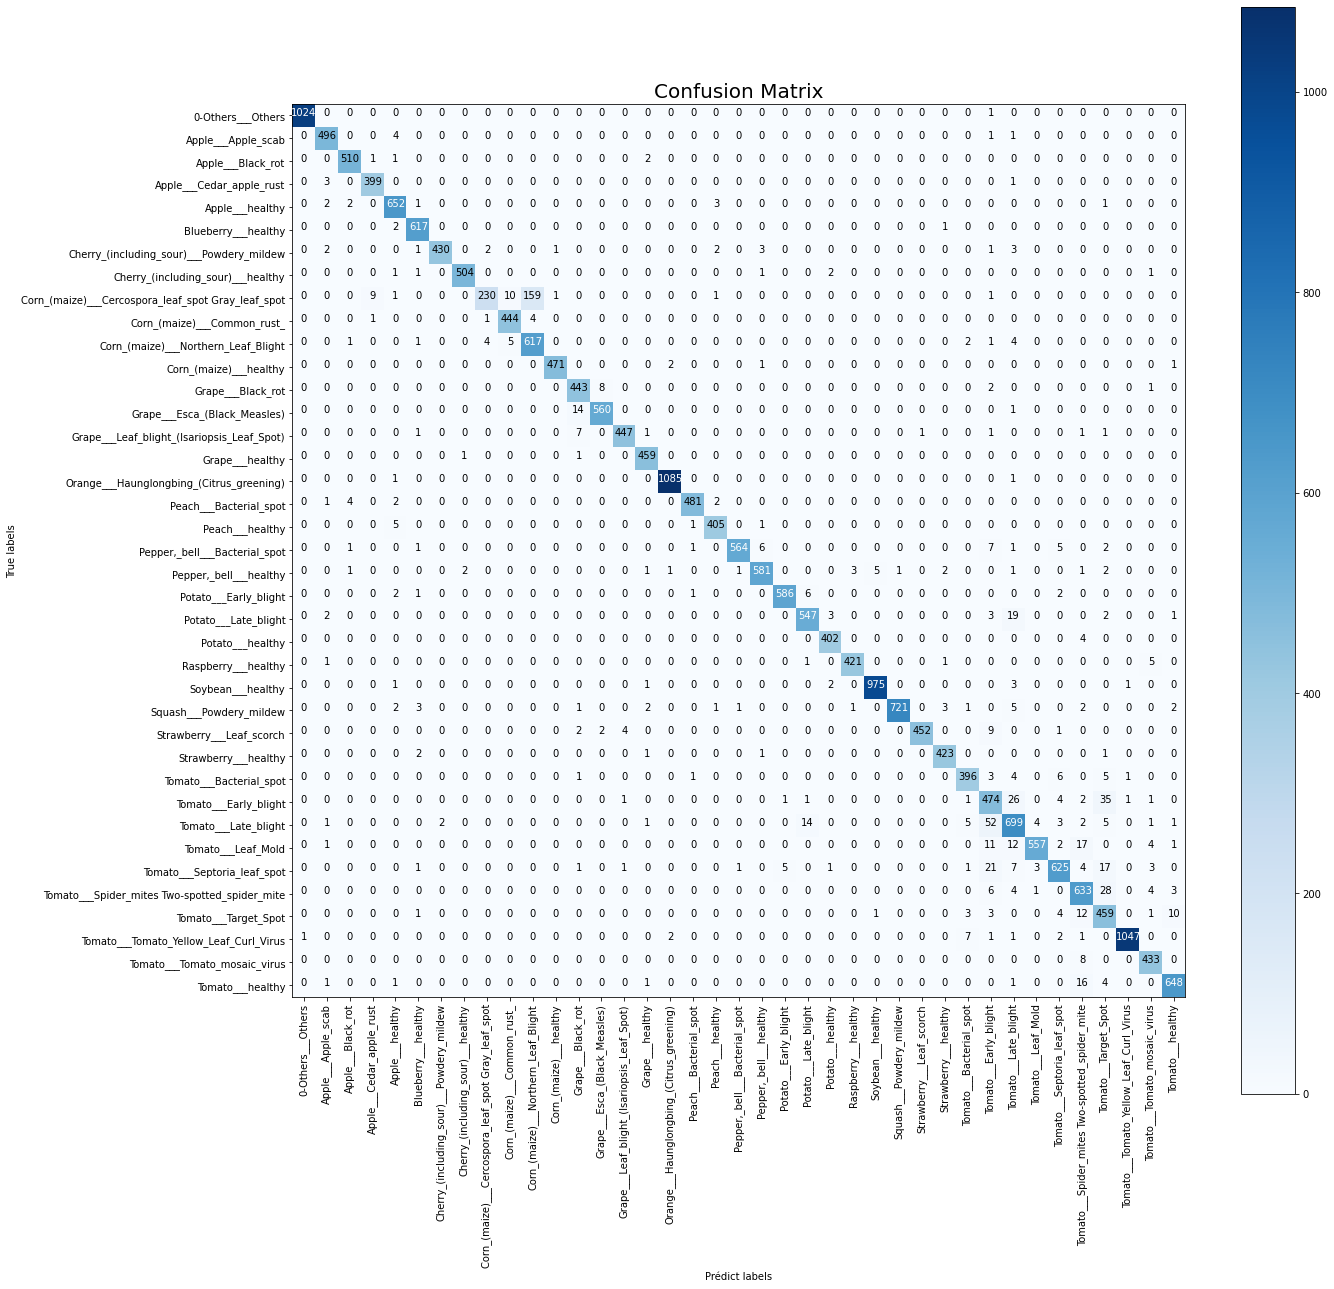

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(labels, pred_labels)
classes = range(0,10)

plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix",fontsize=20)
plt.colorbar()
tick_marks = np.arange(len(unique_plant_cat))

plt.xticks(tick_marks, unique_plant_cat, rotation='vertical')
plt.yticks(tick_marks, unique_plant_cat)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Prédict labels')
plt.show()